# Wikipedia Thanker Study Randomization 
[J. Nathan Matias](https://twitter.com/natematias)
April 27, 2019

This code takes as input data described in the [randomization data format](https://docs.google.com/document/d/1plhoDbQryYQ32vZMXu8YmlLSp30QTdup43k6uTePOT4/edit?usp=drive_web&ouid=117701977297551627494) and produces randomizations for the Thanker study.

TODO: filter out bots

In [140]:
options("scipen"=9, "digits"=4)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(blockTools)
library(blockrand)
library(corrplot)
library(DeclareDesign)
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] corrplot_0.84        DeclareDesign_0.12.0 estimatr_0.14       
 [4] fabricatr_0.6.0      randomizr_0.16.1     blockrand_1.3       
 [7] blockTools_0.6-3     viridis_0.5.1        viridisLite_0.3.0   
[10] forcats_0.3.0        stringr_1.3.1        dplyr_0.7.8         
[13] purrr_0.2.5          rea

# Load Input Dataframe

In [141]:
filename = "all-merged_no_superthankers-20190427.csv"
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/"
thanker.df <- read.csv(file.path(data.path, "historical_survey_superthanker_merged", filename))

In [142]:
colnames(thanker.df)

[1] "user_name"                       "anonymized_id"                  
 [3] "user_id"                         "num_reverts_84_pre_treatment"   
 [5] "wikithank_84_pre_treatment"      "wikilove_84_pre_treatment"      
 [7] "is_official_bot"                 "block_actions_84_pre_treatment" 
 [9] "project_talk_84_pre_treatment"   "support_talk_84_pre_treatment"  
[11] "has_email"                       "anonymized_id.1"                
[13] "pre_newcomer_capability"         "pre_newcomer_intent"            
[15] "pre_emotionally_draining"        "pre_feel_positive"              
[17] "pre_monitoring_damaging_content" "pre_mentoring"                  
[19] "lang"

### Create Aggregate Variables

In [143]:
thanker.df$supportive_84_pre_treatment <- rowSums(thanker.df[,
                                                  c("support_talk_84_pre_treatment",
                                                    "wikithank_84_pre_treatment",
                                                    "wikilove_84_pre_treatment")], na.rm=TRUE)
thanker.df$protective_84_pre_treatment <- rowSums(thanker.df[,
                                                  c("block_actions_84_pre_treatment",
                                                    "num_reverts_84_pre_treatment")], na.rm=TRUE)


thanker.df$is_official_bot <- as.integer(thanker.df$is_official_bot) == 1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


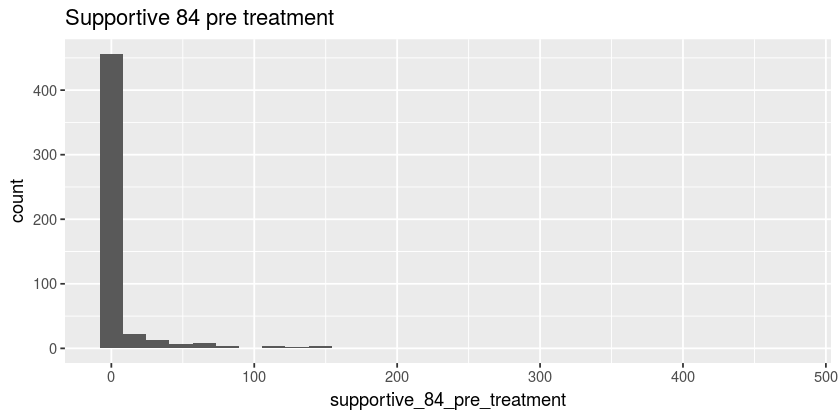

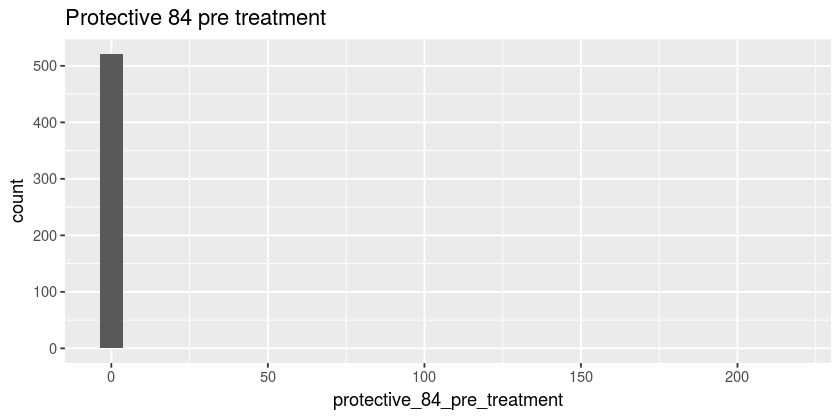

In [144]:
ggplot(thanker.df, aes(supportive_84_pre_treatment)) +
    geom_histogram() +
    ggtitle("Supportive 84 pre treatment")

ggplot(thanker.df, aes(protective_84_pre_treatment)) +
    geom_histogram() +
    ggtitle("Protective 84 pre treatment")

### Remove bots and subset values outside the 99% confidence intervals

In [145]:
print(paste("Removing", nrow(subset(thanker.df, is_official_bot==TRUE)), "officially registered bots"))
thanker.df.final <- subset(thanker.df, is_official_bot != TRUE)

## CALCULATE MEANS AND SDs before making any removals
df.support.mean <- mean(thanker.df$supportive_84_pre_treatment)
df.support.sd   <- sd(thanker.df$supportive_84_pre_treatment)
df.protect.mean <- mean(thanker.df$protective_84_pre_treatment)
df.protect.sd   <- sd(thanker.df$protective_84_pre_treatment)


print(paste("Removing", 
            nrow(subset(thanker.df, 
                        supportive_84_pre_treatment > df.support.mean + 2.58* df.support.sd)),
           "observations because supportive_84_pre_treatment is an outlier."))
thanker.df.final <- subset(thanker.df.final, supportive_84_pre_treatment <= df.support.mean + 2.58* df.support.sd)

print(paste("Removing", 
            nrow(subset(thanker.df.final, 
                        protective_84_pre_treatment > df.protect.mean + 2.58* df.protect.sd)),
           "observations because protective_84_pre_treatment is an outlier."))
thanker.df.final <- subset(thanker.df.final, protective_84_pre_treatment <= df.protect.mean + 2.58* df.protect.sd)


[1] "Removing 2 officially registered bots"
[1] "Removing 12 observations because supportive_84_pre_treatment is an outlier."
[1] "Removing 1 observations because protective_84_pre_treatment is an outlier."


### Illustrate Retained Values

In [146]:
#subset(thanker.df.final, lang=="ar")$wikilove_84_pre_treatment

In [147]:
# Illustrate Consented Thanker Participants
#
#`@param t.df the dataframe to illustrate
illustrate.thanker.data <- function(t.df){
    for(l in unique(t.df$lang)){
        corrplot(cor(t.df[,c("support_talk_84_pre_treatment",
                     "project_talk_84_pre_treatment",
                     "wikithank_84_pre_treatment",
                     "wikilove_84_pre_treatment",
                     "num_reverts_84_pre_treatment")]),
            type="upper", method = "ellipse")

        plt <- ggplot(t.df, aes(protective_84_pre_treatment, supportive_84_pre_treatment)) +
            geom_abline(intercept = 0, color="grey", linetype="dashed") +
            geom_jitter(size=1) +
            scale_colour_gradient(name="% Support Actions") +
            theme_bw() +
            ggtitle(paste(l, "Supportive and Protective Actions Before Treatment"))
        print(plt)

        plt3 <- ggplot(t.df, aes(log1p(wikithank_84_pre_treatment))) +
            geom_histogram() +         
            theme_bw() +
            ggtitle(paste(l, "Thanks Given 84 Days Previously"))

    }
}

Warning message in cor(t.df[, c("support_talk_84_pre_treatment", "project_talk_84_pre_treatment", :
“the standard deviation is zero”Warning message in cor(t.df[, c("support_talk_84_pre_treatment", "project_talk_84_pre_treatment", :
“the standard deviation is zero”

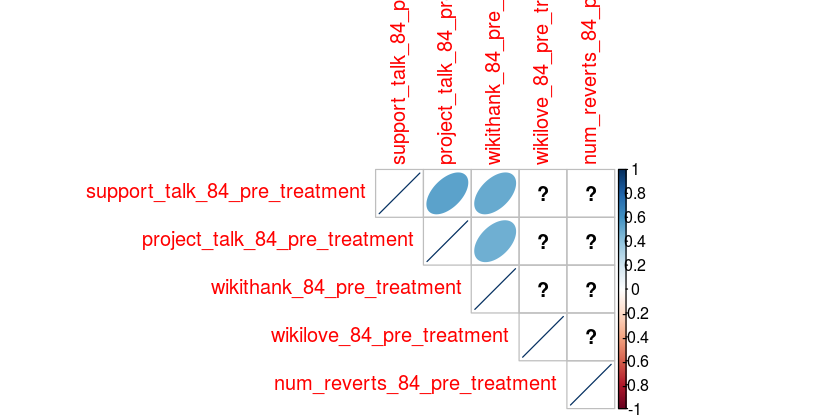

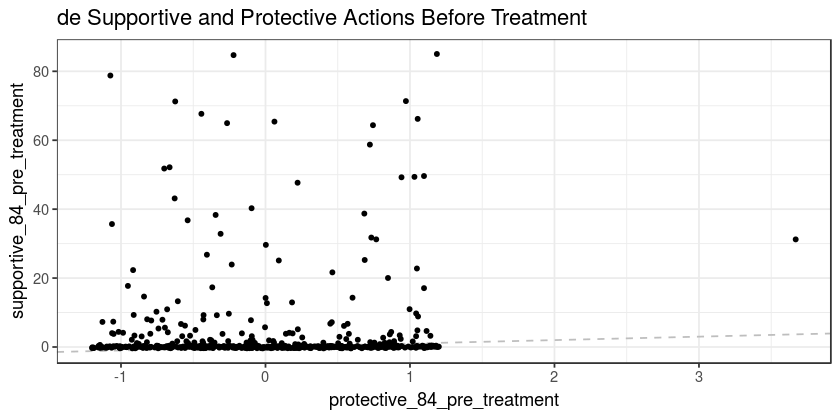

Warning message in cor(t.df[, c("support_talk_84_pre_treatment", "project_talk_84_pre_treatment", :
“the standard deviation is zero”

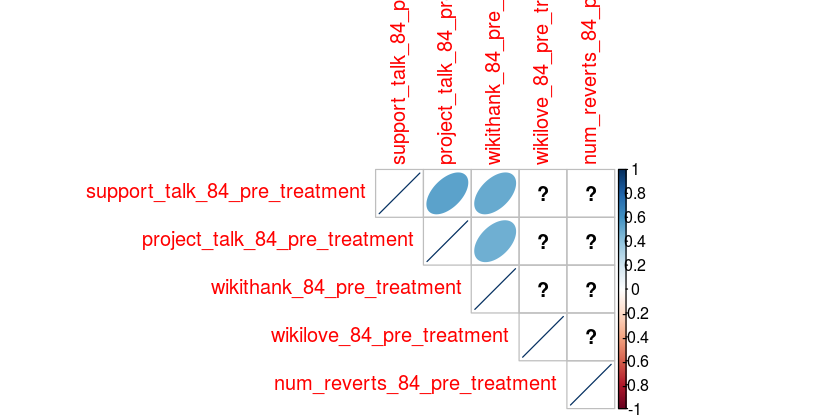

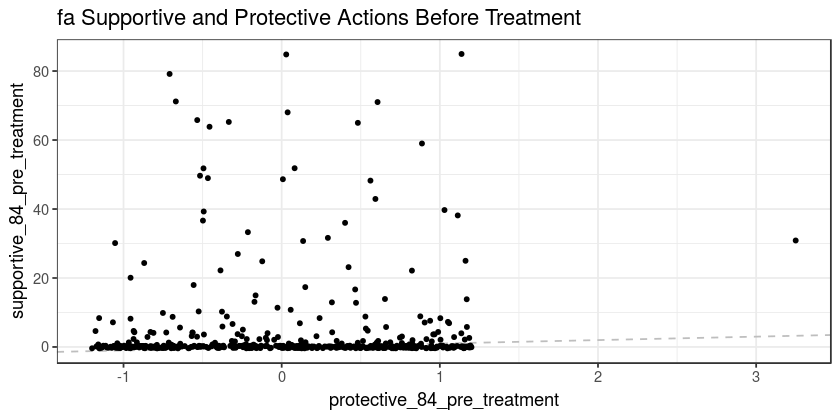

Warning message in cor(t.df[, c("support_talk_84_pre_treatment", "project_talk_84_pre_treatment", :
“the standard deviation is zero”

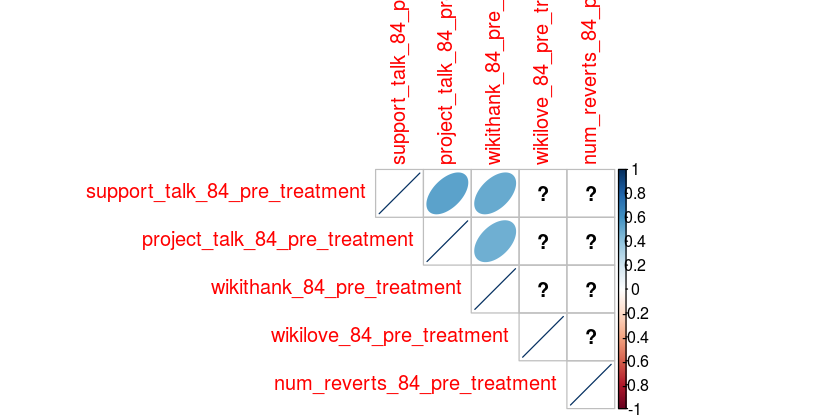

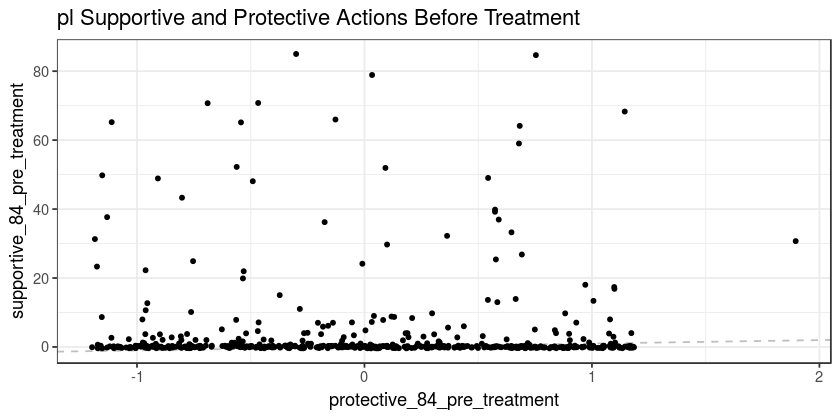

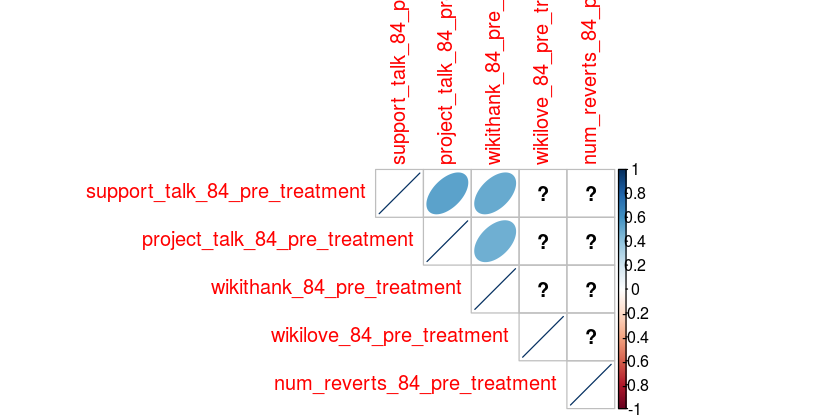

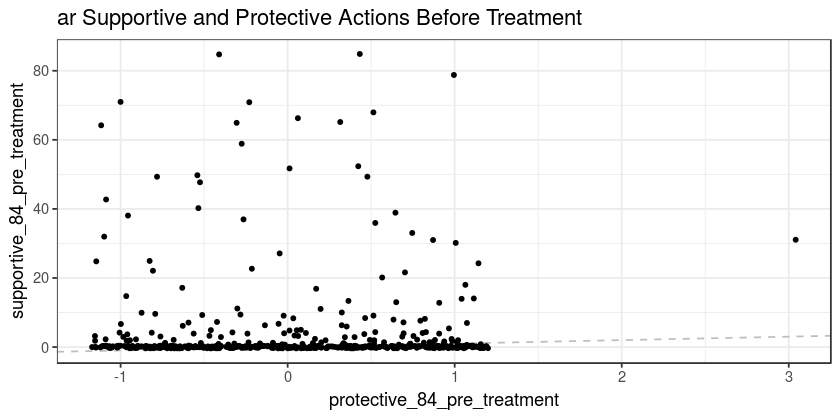

In [148]:
illustrate.thanker.data(thanker.df.final)

### Generate Protectiveness Index

In [149]:
survey.pca <- prcomp(thanker.df.final[c("pre_mentoring", "pre_monitoring_damaging_content",
                                 "pre_newcomer_intent", "pre_newcomer_capability")], center = TRUE ,scale = TRUE)
thanker.df.final$randomization_protectiveness_index <- survey.pca$x[,"PC1"]

Standard deviations (1, .., p=4):
[1] 1.0426 1.0130 0.9899 0.9523

Rotation (n x k) = (4 x 4):
                                    PC1     PC2     PC3     PC4
pre_mentoring                    0.4074 -0.2467  0.8758 -0.0782
pre_monitoring_damaging_content  0.1527  0.8476  0.2091  0.4632
pre_newcomer_intent              0.6530  0.2994 -0.2764 -0.6383
pre_newcomer_capability         -0.6199  0.3621  0.3359 -0.6098

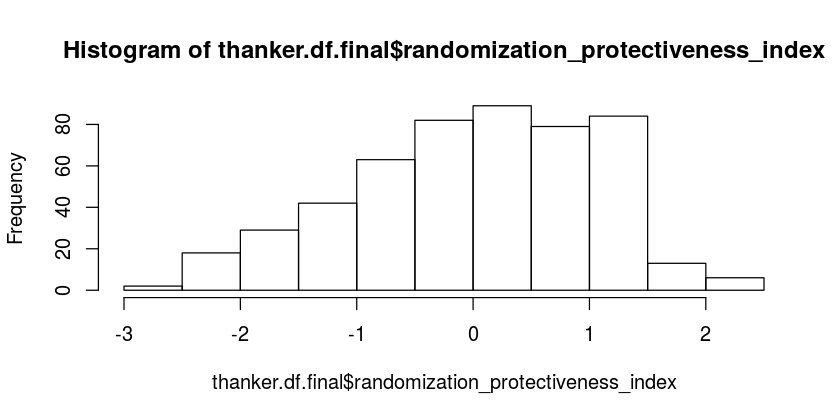

In [150]:
survey.pca
hist(thanker.df.final$randomization_protectiveness_index)

# Generate Randomization Blocks

In [151]:
thanker.df.final$user_id

[1]  651038 1390301   31845 1667080  832603 1759166   19780 1976112  819196
 [10]    4641 1759920 2192234    7782  278091  864614 2017655  209803  265849
 [19]  249487 1021098 1228934  521852  377391  773284   53007  146394  491285
 [28]  458768  642198 1376772   79368  550372  153965  239286   63755  358882
 [37] 1588924  127913 2022044 2545604 1293676 2439159  448171  175885 2772180
 [46] 2120285  117119 2120635  172696  292504  782859 1833619  102157  210218
 [55]  482374 2624415  176056  813705 2363898     423 2434900  387922 2048939
 [64]  173266 1102403 1863619   62920  754953  732590  907829    2457 1652218
 [73]  491882 1766097   23636 2556338   39128 1497965  211504 1284636 1520799
 [82]   24252 1666316  490307   73691 1218753   45059  506809  191811   71953
 [91]  235282  638683   35045   52132 1127153  474536  882763 1895614 1246264
[100] 1650870 1130545  161010  652223  108482  445224 1653506 1826897  248813
[109]  170055 2428671   34986  351765  235307  132759  152137 1158784     336
[118]    9187 1887001  929089  600010   25739 1950440 1094495 2499474 1812845
[127] 2645054   42727  632616  939854   91732  219299   75448  225463  126461
[136] 2119302  203435  117591  383992 2459962 1401247 1104425 1154380  282662
[145] 2522083  397045  311711 1797737    1616  391067  700468  269344 1234349
[154]   59977  545332  952067  397406  289037  756562  600163   47961  200154
[163]  170446  200212  505200  363974   67700  108889   15345  986546  547769
[172] 1434132   66181  851731   26287  268624   37116   40332   14673  394987
[181]  429614   20172  431863  162758 1387424  385129  260547  838173 1731643
[190]  223315  124406    3780 1317928   19725   44212  672669  498842 2228088
[199]  604311   62318 2651537  328878  412743  115481 1470915  496853  236245
[208]   10934   59703  286413   64252 1741674  171729 2698303  497866 2118866
[217]  448533  225458  588902  547803  300006 2614948  633354  716251 2761370
[226]   29831  121584 1706901 1597709  147267   69727  750592  100882   54103
[235] 1144872   64714 1001518  738680 2287614  255832 1922273  598933 1145995
[244]  803154 1656785 2600834 1494059 1353894  813042  521485 1866139   50117
[253]   56403  270127  713935 1034642 2258479 2024898  215600  150819  197228
[262]  139601 1021519  115002  276145  957849 2373322 1564293  840802   46428
[271] 1135718 1240089  374279  682332 1660230   49752  466078  121519   86465
[280]   55586 1722321    9974  496012   97909  989483  324079   44338  731634
[289]  209516  148942  385370  370445  455077    1460  153788    4767  304961
[298]  250426   92110  176346  349670  397810  215294  107851  413951  569340
[307]   61472  366183  328704  608309    5017  368768  238209  147724  139561
[316]  590851     332  552211  206958   12700  331753  545921  176460   81531
[325]  155068  548763  232567  143177   60206  249833  309086  407568  198853
[334]  383002    1294  196124  186423  298779  522739  311788  111342  206492
[343]  592285  294789  248212  429530    8457  110526  335383   31275  592988
[352]  481847   94596  311021  483945  332434  339590   93912  209191  281849
[361]   94020  281715   77215   81400   28096  215845  101344  786964   74320
[370]    6855    5852    8546  721842   18858  163852   39288  375218     487
[379]  770124   97726   13707  332329   19343  146928    6997  179389  471945
[388]    3004  486257   49055  163041    2955  455127   84848  377752   43453
[397]  298453   88084  170730  205612   31354  313142  752969  150613   21428
[406]  207299  759995  201504   14560  378510  221583  103750  277561  489037
[415]    7964   20154  323345   22860  653920  340937   18194  327902   58079
[424]  324537  409942  553223  333918  304960  288830   26816  178616  300974
[433]   11691   10395  173155 1323998  454691  549135  909709  490340  803464
[442]  257614  704874  377985  790700  136037  291805   93905 1290455 1381024
[451] 1045087  175408  519462 1152480  506096  718642 1037769 1379703  594479
[460] 1295007  745233 13

In [152]:
## BLOCKING VARIABLES
bv = c("wikithank_84_pre_treatment", "support_talk_84_pre_treatment","randomization_protectiveness_index")

block.size = 2

## TODO: CHECK TO SEE IF I CAN DO BALANCED RANDOMIZATION
## WITHIN BLOCKS LARGER THAN 2
blockobj = block(data=thanker.df.final,
            n.tr = block.size,
            groups = "lang",
            id.vars="user_id",
            block.vars = bv,
            distance ="mahalanobis"
            )
## CHECK DISTANCES
print(blockobj)
thanker.df.final$randomization_block_id <- createBlockIDs(blockobj,
                                   data=thanker.df.final,
                                   id.var = "user_id")
thanker.df.final$randomization_block_size = block.size


Blocks:

Group: ar 
    Unit 1   Unit 2   Distance
1   1152480  549135   0.00000 
2   118837   1290455  0.00000 
3   1220644  608181   0.00000 
4   1292129  1381024  0.00000 
5   1295007  909709   0.00000 
6   133610   378489   0.00000 
7   251312   175408   0.00000 
8   284119   1300606  0.00000 
9   364154   291805   0.00000 
10  417458   1396353  0.00000 
11  570927   1432803  0.00000 
12  660894   377985   0.00000 
13  969361   136140   0.00000 
14  1252778  173155   0.01585 
15  1433114  745233   0.01585 
16  1347553  1424842  0.02411 
17  258515   269918   0.03776 
18  683736   498144   0.03776 
19  704874   803464   0.03776 
20  632380   1106193  0.03776 
21  764316   257614   0.04079 
22  277416   521473   0.04905 
23  988514   374108   0.05362 
24  594479   718642   0.06187 
25  103043   923524   0.07772 
26  136037   790700   0.07772 
27  506096   454691   0.07772 
28  838758   896558   0.07772 
29  47599    923120   0.12677 
30  333210   143393   0.18039 
31  664557   51946

# Generate Randomizations

In [153]:
## Seed generated by Brooklyn Integers
# https://www.brooklynintegers.com/int/1377541589/
set.seed(1377541589)

In [154]:
assignments <- block_ra(blocks=thanker.df.final$randomization_block_id, 
                        prob=0.5)
thanker.df.final$randomization_arm <- assignments 

In [155]:
print(thanker.df.final$randomization_arm)

  [1] 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0
 [38] 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 [75] 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1
[112] 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0
[149] 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0
[186] 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0
[223] 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0
[260] 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0
[297] 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1
[334] 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0
[371] 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0
[408] 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0
[445] 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 

### Check Balance

In [156]:
aggregate(thanker.df.final$randomization_arm, FUN=mean, by=list(thanker.df.final$lang))

Group.1,x
ar,0.4932
de,0.5000
fa,0.5000
pl,0.5000


# Output and Archive Randomizations

In [157]:
write.csv(thanker.df.final, file.path(data.path, "randomization_output", "all-thanker-randomization-datadrill-20190427.csv"))